In [34]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.tree import plot_tree
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

### Pre processing

In [35]:
df = pd.read_csv('shopping_trends.csv')

df.drop( columns=[ 'Discount Applied', 'Promo Code Used', 'Preferred Payment Method', 'Subscription Status', 'Review Rating', 'Payment Method', 'Shipping Type', 'Frequency of Purchases'], inplace=True)
df.drop_duplicates(inplace=True)

label_encoders = {}
label_mappings = {}  

for column in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le
    label_mappings[column] = dict(enumerate(le.classes_)) 


X = df.drop('Category', axis=1)
y = df['Category']

category_mapping = dict(enumerate(label_encoders['Category'].classes_))


print("\nLabel Mappings for All Categorical Columns:")
for col, mapping in label_mappings.items():
    print(f"\n{col} Mapping: {mapping}")

df.info()




Label Mappings for All Categorical Columns:

Gender Mapping: {0: 'Female', 1: 'Male'}

Item Purchased Mapping: {0: 'Backpack', 1: 'Belt', 2: 'Blouse', 3: 'Boots', 4: 'Coat', 5: 'Dress', 6: 'Gloves', 7: 'Handbag', 8: 'Hat', 9: 'Hoodie', 10: 'Jacket', 11: 'Jeans', 12: 'Jewelry', 13: 'Pants', 14: 'Sandals', 15: 'Scarf', 16: 'Shirt', 17: 'Shoes', 18: 'Shorts', 19: 'Skirt', 20: 'Sneakers', 21: 'Socks', 22: 'Sunglasses', 23: 'Sweater', 24: 'T-shirt'}

Category Mapping: {0: 'Accessories', 1: 'Clothing', 2: 'Footwear', 3: 'Outerwear'}

Location Mapping: {0: 'Alabama', 1: 'Alaska', 2: 'Arizona', 3: 'Arkansas', 4: 'California', 5: 'Colorado', 6: 'Connecticut', 7: 'Delaware', 8: 'Florida', 9: 'Georgia', 10: 'Hawaii', 11: 'Idaho', 12: 'Illinois', 13: 'Indiana', 14: 'Iowa', 15: 'Kansas', 16: 'Kentucky', 17: 'Louisiana', 18: 'Maine', 19: 'Maryland', 20: 'Massachusetts', 21: 'Michigan', 22: 'Minnesota', 23: 'Mississippi', 24: 'Missouri', 25: 'Montana', 26: 'Nebraska', 27: 'Nevada', 28: 'New Hampshir

### Split Data

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Train Models

In [37]:
decision_tree_classifier = DecisionTreeClassifier()
naive_bayes_classifier = GaussianNB()
svm_classifier = SVC(probability=True)
random_forest_classifier = RandomForestClassifier(n_estimators=100)

In [38]:
def train_model(model, name):
    start_time = time.time() 
    model.fit(X_train, y_train)
    end_time = time.time() 
    training_time = end_time - start_time 
    print(f"{name} trained in {training_time:.4f} seconds.")

In [39]:
train_model(decision_tree_classifier, "Decision Tree")

Decision Tree trained in 0.0048 seconds.


In [40]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=500)
rfe = RFE(model, n_features_to_select=10)
rfe.fit(X_train, y_train)

selected_features = X_train.columns[rfe.support_]
print("Selected Features: ", selected_features.tolist())


c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_rfe.py:300: UserWarning: Found n_features_to_select=10 > n_features=9. There will be no feature selection and all features will be kept.
  warnings.warn(


Selected Features:  ['Age', 'Gender', 'Item Purchased', 'Purchase Amount (USD)', 'Location', 'Size', 'Color', 'Season', 'Previous Purchases']


c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


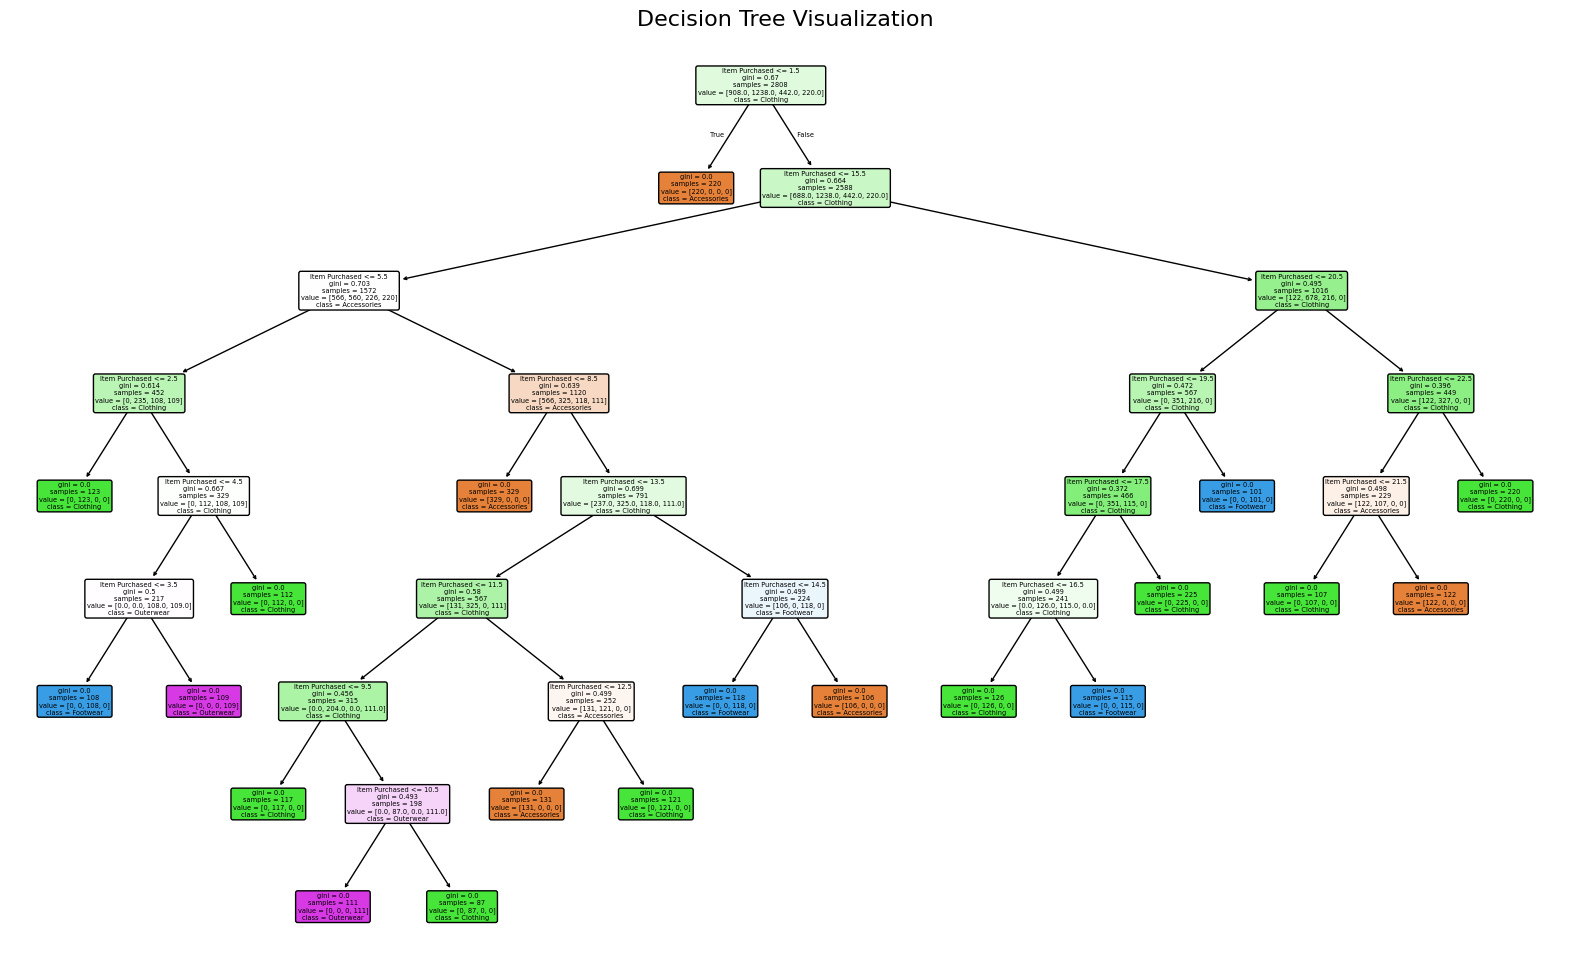

In [41]:
plt.figure(figsize=(20, 12))

plot_tree(
    decision_tree_classifier,
    filled=True,
    feature_names=X.columns,
    class_names=[category_mapping[label] for label in sorted(set(y))],
    rounded=True,
)

plt.title("Decision Tree Visualization", fontsize=16)
plt.show()


In [42]:
train_model(naive_bayes_classifier, "Naive Bayes")

Naive Bayes trained in 0.0021 seconds.


In [43]:
train_model(svm_classifier, "SVM Classifier")

SVM Classifier trained in 1.4173 seconds.


In [44]:
train_model(random_forest_classifier, "Random Forest Classifier")

Random Forest Classifier trained in 0.2989 seconds.


### Model Metrics

In [45]:
def check_model_metrics(model, name):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test) if hasattr(model, "predict_proba") else None

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="weighted", zero_division=1)
    recall = recall_score(y_test, y_pred, average="weighted", zero_division=1)
    roc_auc = roc_auc_score(y_test, y_prob, multi_class="ovr") if y_prob is not None else None
    cm = confusion_matrix(y_test, y_pred)

    cross_val = cross_val_score(model, X_train, y_train, cv=10).mean()

    print(f"{name} Metrics")
    print(f"Confusion Metrix: \n{cm}")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"ROC-AUC: {roc_auc}")
    print('\n\n')

check_model_metrics(naive_bayes_classifier, "Naive Bayes")
check_model_metrics(svm_classifier, "SVM Classifier")
check_model_metrics(random_forest_classifier, "Random Forest Classifier")
    


Naive Bayes Metrics
Confusion Metrix: 
[[105  98   0   0]
 [ 83 239   0   0]
 [ 21  86   0   0]
 [ 41  29   0   0]]
Accuracy: 0.49002849002849
Precision: 0.6161268688702317
Recall: 0.49002849002849
ROC-AUC: 0.6881252614178219



SVM Classifier Metrics
Confusion Metrix: 
[[111  92   0   0]
 [ 76 246   0   0]
 [ 21  86   0   0]
 [ 38  32   0   0]]
Accuracy: 0.5085470085470085
Precision: 0.6300685004150987
Recall: 0.5085470085470085
ROC-AUC: 0.6840573618124862



Random Forest Classifier Metrics
Confusion Metrix: 
[[200   2   1   0]
 [  1 320   1   0]
 [  1  28  78   0]
 [  2  22   0  46]]
Accuracy: 0.9173789173789174
Precision: 0.9264015030697511
Recall: 0.9173789173789174
ROC-AUC: 0.9950045627145182



